<a id="top"></a>
# Working with FIMS-SPEAR Hyperspectral HEALPix Maps

## Learning Goals


**In this tutorial, you will learn how to retrieve, extract, manipulate, and plot data from [FIMS-SPEAR](https://archive.stsci.edu/missions-and-data/fims-spear), a [MAST Community-Contributed Mission](https://archive.stsci.edu/new-mission-partnerships-with-mast).** By the end of this tutorial, you will be able to plot hyperspectral HEALPix maps in various projections and extract spectra from spatial regions of interest.

## Introduction

Launched on 2003 September 27, FIMS-SPEAR conducted the first large-area spectral survey of the far-ultraviolet sky, a band which spans warm and hot plasma cooling lines, molecular hydrogen fluorescent emission, and dust-scattered starlight. The astronomical data and the [mission manual](https://outerspace.stsci.edu/display/SPEARFIMS) are hosted by the Mikulski Archive for Space Telescopes (MAST).

The FIMS-SPEAR instrument comprised dual imaging spectrographs optimized for measuring diffuse emission, including the "Short" S-band (900–1150 Å) and the "Long" L-band (1350–1710 Å). The instrument was capable of spatial resolutions down to 5 arcmin, and a spectral resolving power around λ/Δλ=550 in both bands. Available data products include hyperspectral imaging covering most of the sky, extracted line emission maps, star spectra, and pointed observations of the Vela supernova remnant.

**This demo is primarily concerned with the hyperspectral imaging survey. The all-sky data were spatially binned using the HEALPix scheme** ([Hierarchical Equal Area isoLatitude Pixelation](https://healpix.sourceforge.io/index.php)). A couple key features include:
1. HEALPixelization subdivides the spherical surface of the sky into curvilinear quadrilaterals pixels, with each pixel's surface area equal to that of every other pixel. 
2. HEALPix maps parameterize the two spatial dimensions of sky coordinates as a one-dimensional array, following a pre-determined pixel ordering scheme. 

**FIMS-SPEAR hyperspectral HEALPix maps are highly unusual in that they also have a wavelength axis, with a spectrum for each HEALPixel.** Standard HEALPix software like [`healpy`](https://healpy.readthedocs.io/en/latest/) are not currently set up to handle hyperspectral data by default. In this tutorial, we will show how to make FIMS-SPEAR hyperspectral data tractable by `healpy`.

In this notebook, you will:
1. Load the hyperspectral HEALPix map data, wrangle them into a usable form, and learn about their FITS headers
2. Plot some all-sky maps and spectra
3. Trim the wavelength axis and use coordinate rotator functions to compare FIMS vs. SPEAR data products
4. Plot a cartesian projection of the Vela supernova remnant and extract its spectrum
5. Extract spectra from a variety of custom regions around the Aquila Rift

## Imports
This notebook uses the following packages:
- `healpy` to handle HEALPix data
- `numpy` to handle array operations
- `astropy` for working with FITS files, table data, and units
- `copy` for deep copy operations
- `matplotlib.pyplot` for plotting data
- `specutils` for smoothing spectra
- `Ipython.display` for displaying figure titles
- `astroquery.mast` and `os` for file downloads


If you do not have these packages installed, you can install them using [`conda`](https://docs.conda.io/en/latest/) or [`pip`](https://pip.pypa.io/en/stable/).

In [ ]:
# healpy software for wrangling HEALPix maps
import healpy as hp

# arrays
import numpy as np

# table operations to help with wrangling hyperspectral HEALPix maps
from astropy.table import Table
from astropy.table.pprint import conf

# FITS
from astropy.io import fits

# deep copy operations
import copy

# plotting
import matplotlib.pyplot as plt
from IPython.display import Markdown, display

# spectrum smoothing
from specutils import Spectrum1D
import specutils.manipulation
from astropy import units as u

# downloads
from astroquery.mast import Observations
import os

In [ ]:
# Fixing a few global settings
%matplotlib inline
plt.rcParams.update({'font.size': 10})
plt.rcParams['figure.figsize'] = (9.5, 5.85)
conf.max_lines = 10 # Max lines for astropy.Table in-notebook display

## Tutorial
### 1. Download and wrangle the data

`healpy` was designed to work with maps that describe how a measured quantity varies as a function of position on the sky. For example, we can read in the SPEAR team's C IV integrated emission line map using the built-in function `healpy.fitsfunc.read_map`:

In [ ]:
# Download the SPEAR C IV emission line map with adaptive binning
uri0 = 'mast:MCCM/fims-spear/spear/hp-map/adaptive/mccm_fims-spear_spear-ap100-adaptive_sky-starless_long-c-iv_v1.0_hp-map.fits'
Observations.download_file(uri0) # 15 MB

In [ ]:
display(Markdown("<font size=6>Fig. 1: C IV map (adaptive binning)</font>"))

# Read it in with read_map
civ = hp.fitsfunc.read_map('mccm_fims-spear_spear-ap100-adaptive_sky-starless_long-c-iv_v1.0_hp-map.fits')

# Plot it. This product is in Ecliptic coordinates, 
# so we use coord=['E','G'] to plot it in Galactic coordinates.
hp.mollview(civ, coord=['E', 'G'], max=5e4, unit='photon cm-2 s-1 sr-1', title='')

> <center>Fig. 1 image description: all-sky map of integrated intensity from the C IV emission line, with adaptive binning that gets smaller in regions with high intensity (like the Vela supernova remnant towards the right, the brightest part of the map).</center>

But hyperspectral maps are a little bit more complicated, and `healpy.fitsfunc.read_map` won't work for them.

Let's download several hyperspectral HEALPix maps created by the FIMS team: Nside=64 for both bands, and an additional higher-Nside map for L-Band. The spatial resolution of a HEALPix scheme is parameterized as `Nside`, which is equal to the number of subdivisions along the side of a baseline HEALPixel (where the baseline HEALPixel at Nside=1 spans 1/12th of the sky). 

In [ ]:
uri1 = 'mast:MCCM/fims-spear/fims/hp-map-hsi/mccm_fims-spear_fims-ap100-n064_sky-starless_long_v1.0_hp-map-hsi.fits.gz'
uri2 = 'mast:MCCM/fims-spear/fims/hp-map-hsi/mccm_fims-spear_fims-ap100-n064_sky-starless_short_v1.0_hp-map-hsi.fits.gz'
uri3 = 'mast:MCCM/fims-spear/spear/hp-map-hsi/mccm_fims-spear_spear-ap100-n064_sky-starless_long_v1.0_hp-map-hsi.fits.gz'
uri4 = 'mast:MCCM/fims-spear/spear/hp-map-hsi/mccm_fims-spear_spear-ap100-n064_sky-starless_short_v1.0_hp-map-hsi.fits.gz'

Observations.download_file(uri1) # 110 MB
Observations.download_file(uri2) # 50 MB
Observations.download_file(uri3) # 50 MB
Observations.download_file(uri4) # 20 MB

For our high-resolution map, it would be ideal to use the highest resolution available, Nside=512. But that would be 4.5 GB compressed on-disk, and 12 GB decompressed into memory. So for this demonstration we'll default to a special Nside=256 map that only contains data in the regions that we need.

**If you have a good internet connection and sufficient RAM, we highly recommend that you comment out the first cell below, and uncomment the second cell, for the full FIMS-SPEAR experience. Everything in this notebook will work either way!**

In [ ]:
# Use this cell if you have a limited internet connection or limited RAM.

nside_highres = 256 # Download the Nside=256 map cutout
uri5 = 'mast:MCCM/fims-spear/tutorial/mccm_fims-spear_fims-ap100-n256_tutorial-cutout-starless_long_v1.0_hp-map-hsi.fits.gz' # tutorial cutout map

In [ ]:
# # Uncomment this cell to use the full Nside=512 map instead:

# nside_highres = 512 # Download the Nside=512 full map
# uri5 = 'mast:MCCM/fims-spear/fims/hp-map-hsi/mccm_fims-spear_fims-ap100-n512_sky-starless_long_v1.0_hp-map-hsi.fits.gz' # full map

In [ ]:
# Execute this cell either way:

Observations.download_file(uri5) # 360 MB (or 4.5 GB if the second cell above is executed)
file_highres = os.path.basename(uri5)

Before we delve into the details, let's first demonstrate that it only takes two lines of code to load up a FIMS-SPEAR hyperspectral HEALPix map, integrate it over wavelength, and plot it:

In [ ]:
display(Markdown("<font size=6>Fig. 2: Integrated intensity map</font>"))

# Load the data with astropy.
l_n064 = Table.read('mccm_fims-spear_fims-ap100-n064_sky-starless_long_v1.0_hp-map-hsi.fits.gz', 
                    hdu=1).filled(np.nan) # The ".filled(np.nan)" is important; see "a note about NaNs" below.

# Integrate over wavelength and plot the data.
hp.mollview(np.sum(l_n064['INTEN_BSUB'], axis=1), coord='G', max=5e6, unit='photon cm-2 s-1 sr-1', title='') # Galactic coordinates

> <center>Fig. 2 image description: all-sky map of integrated intensity. The Galactic plane is seen as regions of high intensity.</center>

Done! But it will help to understand why this worked and how the data is structured, so let's take a look at the FITS header:

In [ ]:
hdul = fits.open('mccm_fims-spear_fims-ap100-n064_sky-starless_long_v1.0_hp-map-hsi.fits.gz')

hdul.info()

The file consists of a primary header data unit and a binary table extension. The primary only contains a header, reporting general information about the observations:

In [ ]:
hdul[0].header

The data is in the extension. After some basic info, the BINTABLE extension's header is divided into three parts.
1. Information from which you can construct the wavelength array. This section is not usually in a HEALPix header; FIMS-SPEAR is the first publically-archived data in which a hyperspectral map is being stored in a HEALPix arrangement!

2. Information about the HEALPixelization scheme. Note that the total number of HEALPixels (spatial bins) is equal to `12 x NSIDE^2 = NAXIS2 = LASTPIX + 1`. This will be true for all FIMS-SPEAR HEALPix maps.

3. Information about the "columns" of the binary table, including their structure and astronomical units. We'll learn more about this table soon.

In [ ]:
hdul[1].header

Note that FIMS-SPEAR data follows the "RING" pixel ordering scheme (in which the pixel number winds down from the north to south pole through consecutive isolatitude rings), with "IMPLICIT" indexing (meaning that a value is provided for every pixel on the sky, even if that value is NaN).

**Important:** Each HEALPixel contains a spectrum, and the current version of `healpy` can't handle this addition of the wavelength axis without a little data wrangling. So we'll start by reading in the binary tables with `astropy.Table`:

In [ ]:
hdul.close()

l_n064 = Table.read('mccm_fims-spear_fims-ap100-n064_sky-starless_long_v1.0_hp-map-hsi.fits.gz', 
                    hdu=1).filled(np.nan)

s_n064 = Table.read('mccm_fims-spear_fims-ap100-n064_sky-starless_short_v1.0_hp-map-hsi.fits.gz', 
                    hdu=1).filled(np.nan)

l_highres = Table.read(file_highres,
                       hdu=1).filled(np.nan) # this one may take a minute

(A note about NaNs: You might be wondering why we needed `.filled(np.nan)`. There are regions of the sky without coverage by FIMS-SPEAR, which are represented as NaN values in the FITS binary table. By default, `astropy.Table` masks these pixels with the `numpy` fill value for masking floats, 1e20. But the `healpy` fill value for masking bad data is -1.6375e+30. Plus, we're sometimes going to need to sum arrays over the wavelength axis, and we don't want to sum up either of these fill values. So, here we're bypassing the problem entirely by using NaNs instead of masking fill values.)

Let's take a look at the L-band, Nside=64 table.

In [ ]:
l_n064

This table has 49152 rows, equal to the number of HEALPixels in the map (`12 x Nside^2`). The columns and their units correspond to the `TTYPEi` and `TUNITi` keywords in the FITS extension header.

EXP-SLIT ([the FIMS definition of exposure time](https://outerspace.stsci.edu/display/SPEARFIMS/Exposure+Time+Calculation)) is a simple HEALPix map, with one value per HEALPixel. But for the other columns, each HEALPixel contains an array of length 340, giving the value in each wavelength bin. 

In [ ]:
print(len(l_n064['INTEN_BSUB'][0]))

For our final piece of data wrangling, let's create the wavelength arrays:

In [ ]:
# S-band
with fits.open('mccm_fims-spear_fims-ap100-n064_sky-starless_short_v1.0_hp-map-hsi.fits.gz') as hdul:
    crval = hdul[1].header['CRVAL1']
    cdelt = hdul[1].header['CDELT1']
    bins = len(s_n064['INTEN_BSUB'][0])
    swave = np.arange(0, bins)*cdelt+crval
    print(f'S-band: {min(swave)} to {max(swave)} Angstrom, {bins} bins')

# L-band
with fits.open('mccm_fims-spear_fims-ap100-n064_sky-starless_long_v1.0_hp-map-hsi.fits.gz') as hdul:
    crval = hdul[1].header['CRVAL1']
    cdelt = hdul[1].header['CDELT1']
    bins = len(l_n064['INTEN_BSUB'][0])
    lwave = np.arange(0, bins)*cdelt+crval
    print(f'L-band: {min(lwave)} to {max(lwave)} Angstrom, {bins} bins')

### 2. All-sky maps and spectra

First, we'll make all-sky maps of total intensity integrated over wavelength:

In [ ]:
# Integrated intensity maps (background-subtracted)
l_n064_map = np.sum(l_n064['INTEN_BSUB'], axis=1) # integrate over wavelength
s_n064_map = np.sum(s_n064['INTEN_BSUB'], axis=1)
l_highres_map = np.sum(l_highres['INTEN_BSUB'], axis=1)

print(l_n064_map.shape)
print(s_n064_map.shape)
print(l_highres_map.shape)

Next, we'll make all-sky, spatially-averaged intensity spectra. 

But first, a small detour: when extracting a spatially-averaged spectrum from some region of the sky, computing a simple average will in many cases lead to spiky artifacts in the averaged spectrum, due to low signal-to-noise in HEALPixels with extremely low exposure time. The effect is strongest at low Nside. 

Instead, you should strongly consider weighting the intensity by exposure time, essentially giving up on a spatially uniform average in order to achieve improved signal-to-noise. That's what we'll do in this notebook. 

_Note: regardless of which method you use, if the exact shape of the extraction region is important to your science, you should pay close attention to the exposure map in your extraction region._

**Important:** we need to use numpy.nansum, numpy.nanmean etc. when integrating over the spatial axis, to handle the HEALPixels without sky coverage. So let's first define a NaN-compatible function to compute an exposure-weighted average spectrum:

In [ ]:
def weighted_spatial_average(inten, exp):
    return np.nansum((inten.T*exp).T, axis=0)/np.nansum(exp)

# Inputs: hyperspectral intensity map (2D), exposure map (1D)
# Assumes the shape of inten is (HEALPixels, wavelengths)
# Returns sum(intensity*exposure)/sum(exposure)

Now, we'll use that function to compute exposure-weighted all-sky spectra:

In [ ]:
# Maps of spatially-averaged spectra
l_n064_spec = weighted_spatial_average(l_n064['INTEN_BSUB'], l_n064['EXP-SLIT']) # integrate over spatial coordinate
s_n064_spec = weighted_spatial_average(s_n064['INTEN_BSUB'], s_n064['EXP-SLIT'])
l_highres_spec = weighted_spatial_average(l_highres['INTEN_BSUB'], l_highres['EXP-SLIT'])

print(l_n064_spec.shape)
print(s_n064_spec.shape)
print(l_highres_spec.shape)

Now we're ready to use `healpy`, which is designed to plot HEALPix maps! Let's start with the low-resolution, Nside=64 map, in which each HEALPixel is 55 arcmin in size:

In [ ]:
# healpy plot settings
min1, max1 = 0, 3e6 # intensity range for colorbar
interval = 15 # healpy graticule spacing in degrees

In [ ]:
display(Markdown("<font size=6>Fig. 3: Integrated intensity maps and all-sky spectra</font>"))

# Setting up the figure

fig, ax = plt.subplot_mosaic("AB;CD")
ax['A'].axis('off')
ax['B'].axis('off')

# Plotting the spatial map

hp.mollview(l_n064_map, sub=(2, 2, 1), min=min1, max=max1, title='L-band, Nside=64 (photon cm-2 s-1 sr-1)', 
            coord='G', notext=True)

hp.mollview(s_n064_map, sub=(2, 2, 2), min=min1, max=max1*2., title='S-band,  Nside=64 (photon cm-2 s-1 sr-1)',
            coord='G', notext=True)

hp.graticule(dpar=interval, dmer=interval)


# Plotting the spatially-averaged spectra

ax['C'].plot(lwave, l_n064_spec) # L-band
ax['C'].set_xlabel(r'Wavelength [$\AA$]')
ax['C'].set_ylabel(r'photon cm-2 s-1 sr-1 Å-1')
ax['C'].set_xlim(np.amin(lwave), np.amax(lwave))


ax['D'].plot(swave, s_n064_spec) # S-band
ax['D'].set_xlabel(r'Wavelength [$\AA$]')
ax['D'].set_xlim(np.amin(swave), np.amax(swave))
ax['D'].set_ylim(2000., 14000.)

plt.show()

> <center>Fig. 3 image description: The top row shows all-sky integrated intensity in the L and S bands; the S-band data is much noisier. The bottom row shows the averaged all-sky spectrum, displaying many strong emission lines in both bands.</center>

Let's also make count maps integrated over wavelength, and plot them alongside the exposure maps:

In [ ]:
# Integrated count maps
l_n064_cmap = np.sum(l_n064['COUNT'], axis=1) # integrate over wavelength
s_n064_cmap = np.sum(s_n064['COUNT'], axis=1)

In [ ]:
display(Markdown("<font size=6>Fig. 4: Integrated count maps and exposure maps</font>"))

# Setting up the figure
margins = [0.03, 0.03, 0.03, 0.03]

fig, ax = plt.subplot_mosaic("AB;CD")
ax['A'].axis('off')
ax['B'].axis('off')
ax['C'].axis('off')
ax['D'].axis('off')

# Plotting the spatial map

hp.mollview(l_n064_cmap, sub=(2, 2, 1), min=min1, max=1000, title='L-band, Nside=64 (photon/pix)', 
            coord='G', notext=True, margins=margins)

hp.mollview(s_n064_cmap, sub=(2, 2, 2), min=min1, max=1000, title='S-band,  Nside=64 (photon/pix)',
            coord='G', notext=True, margins=margins)

hp.mollview(l_n064['EXP-SLIT'], sub=(1, 2, 1), min=min1, max=40, title='L-band, Nside=64 (s/slitwidth^2)', 
            coord='G', notext=True, margins=margins)

hp.mollview(s_n064['EXP-SLIT'], sub=(1, 2, 2), min=min1, max=40, title='S-band,  Nside=64 (s/slitwidth^2)',
            coord='G', notext=True, margins=margins)

hp.graticule(dpar=interval, dmer=interval)

plt.show()

> <center>Fig. 4 image description: The top row shows all-sky integrated count maps in the L and S bands, and the bottom row shows exposure maps in the L and S bands. The count maps and the exposure maps look similar. </center>

Many fewer counts were detected in S-band compared to L-band, even though their exposure times were broadly similar. This is because [the S-band detector suffered from a severe loss of sensitivity during manufacturing](https://outerspace.stsci.edu/display/SPEARFIMS/Design).

Finally, let's take a quick look at an Nside=512 map, in which each HEALPixel is about 7 arcmin in size:

In [ ]:
# # If you downloaded the full 4.5 GB, Nside=512 map, uncomment this cell and plot it yourself:

# display(Markdown("<font size=6>Fig. 5: High-resolution integrated intensity map</font>"))
# hp.mollview(l_highres_map, min=min1, max=max1, coord='G', unit='photon cm-2 s-1 sr-1', title='', notext=True)

<font size=6>Fig. 5: High-resolution integrated intensity map</font>
![highres_map.png](highres_map.png)
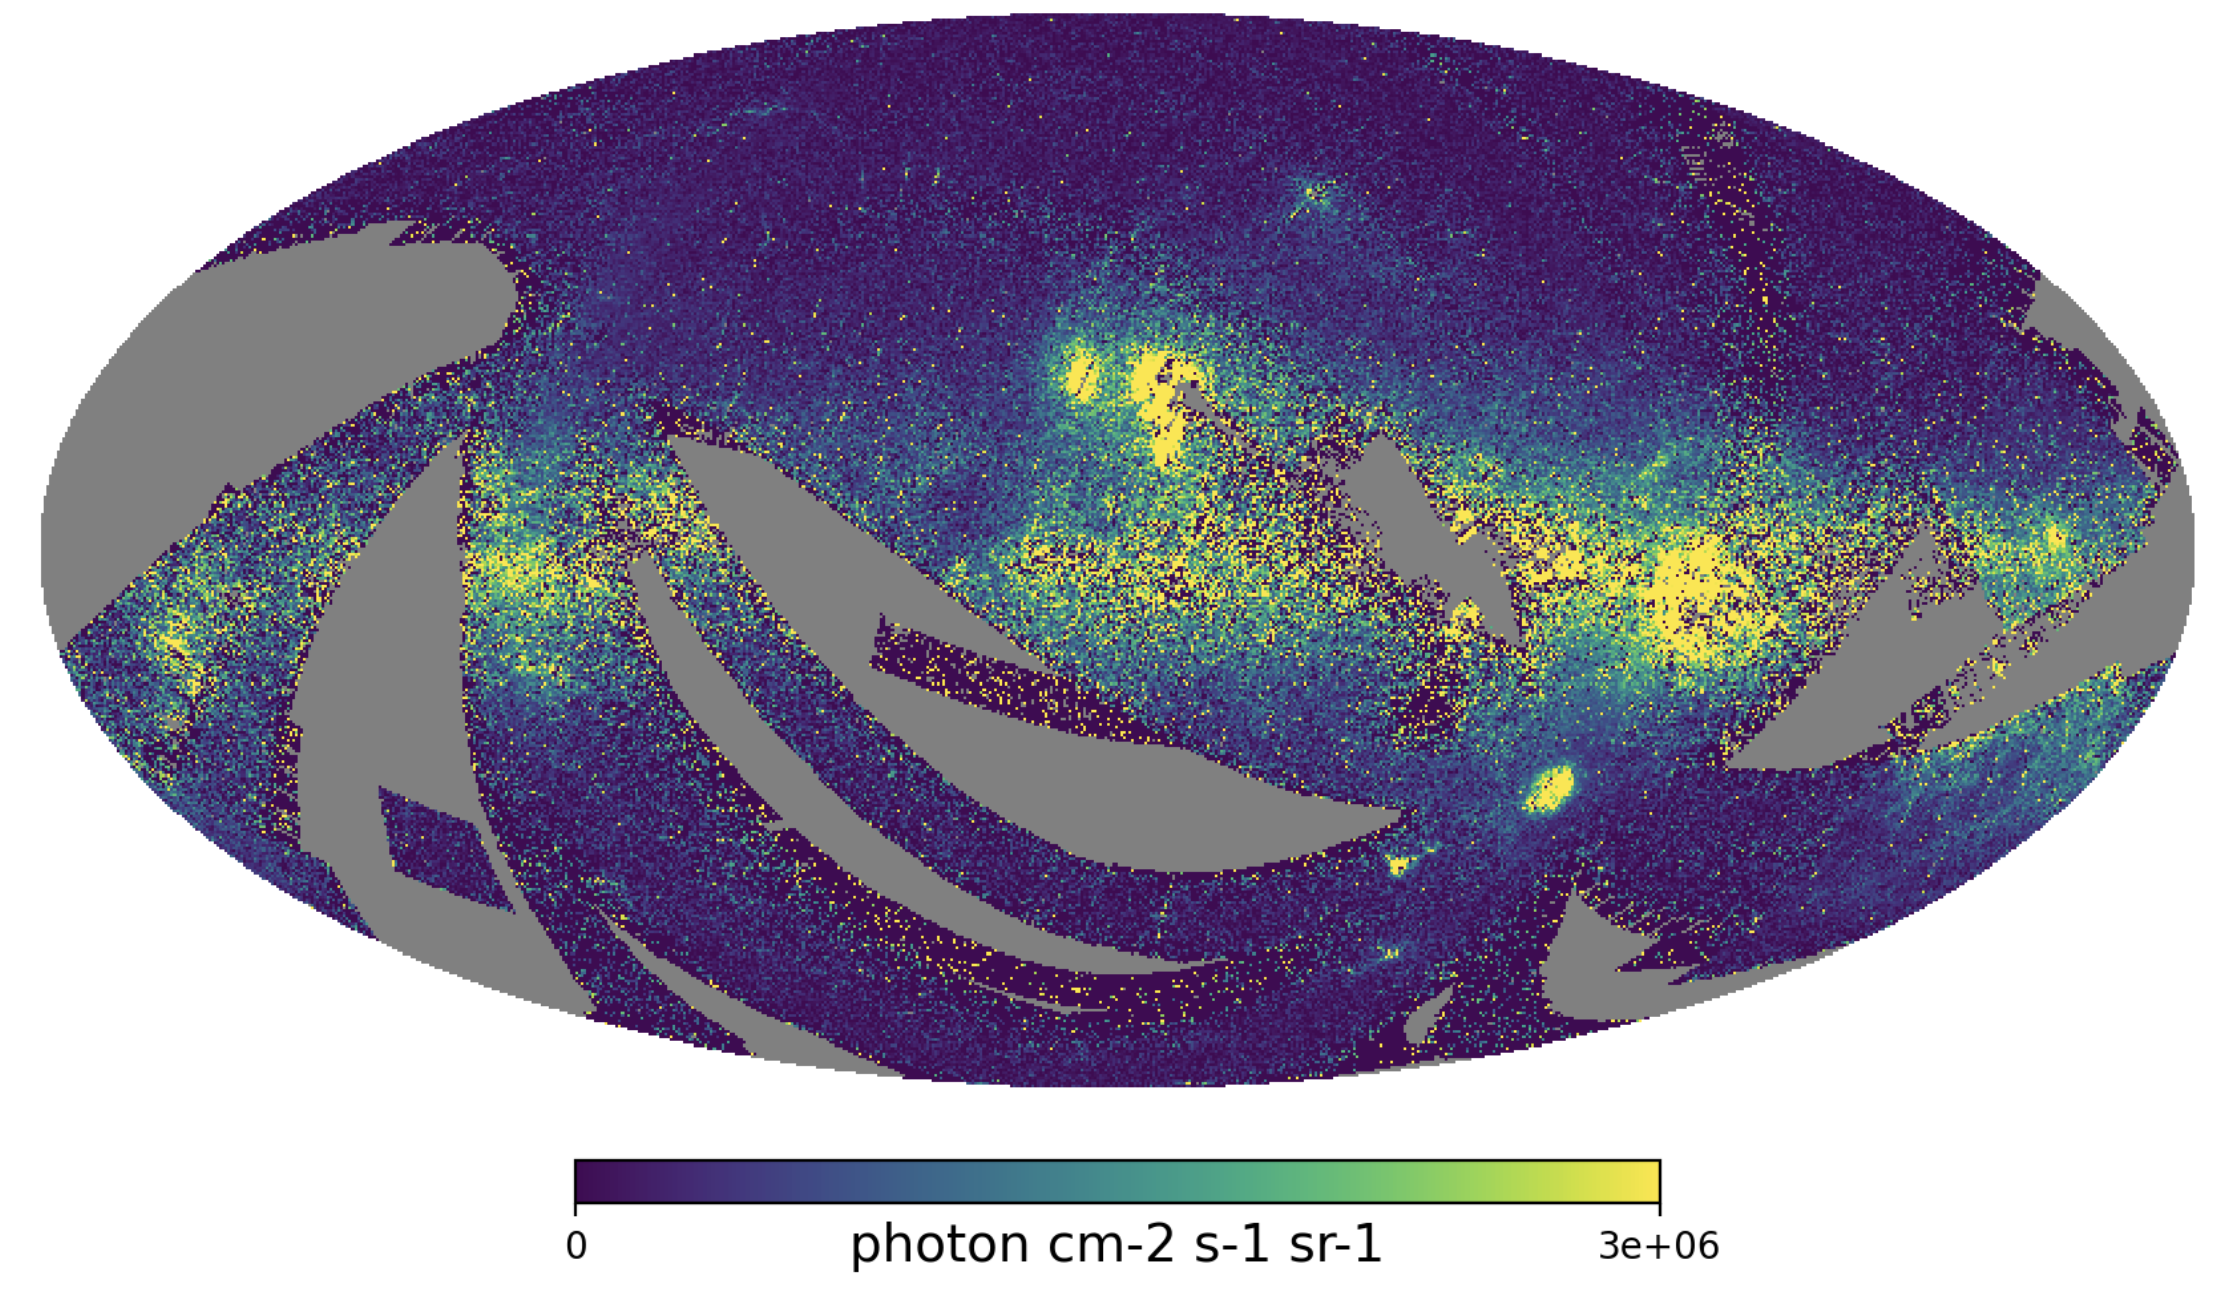

><center>Fig. 5 image description: The Nside=512 integrated intensity all-sky map is chaotically sprinkled with many small dots of high and low intensity.</center>

It's noisier, but as we'll see in Sections 4 and 5, still very useful!

### 3. Slicing and rotating (Comparing FIMS vs. SPEAR data)

Until now, we've focused on data products created by the FIMS team. The FIMS-SPEAR mission products at MAST include products produced by the FIMS team's pipeline and by the SPEAR team's pipeline, with [a variety of complex differences between the two](https://outerspace.stsci.edu/display/SPEARFIMS/FIMS+vs.+SPEAR+Features).

In this section, let's compare the FIMS and SPEAR data by dividing or subtracting their integrated intensity maps. To do that, we'll first have to slice off some vignetted edges in the SPEAR team's data, and rotate the coordinate systems to match each other.

Let's load up the SPEAR team's data:

In [ ]:
# Load the data
l_n064_spear = Table.read('mccm_fims-spear_spear-ap100-n064_sky-starless_long_v1.0_hp-map-hsi.fits.gz', 
                          hdu=1).filled(np.nan)
s_n064_spear = Table.read('mccm_fims-spear_spear-ap100-n064_sky-starless_short_v1.0_hp-map-hsi.fits.gz', 
                          hdu=1).filled(np.nan)

In [ ]:
# Make the SPEAR wavelength arrays
# (same procedure as before, condensed into fewer lines at the expense of readability)
with fits.open('mccm_fims-spear_spear-ap100-n064_sky-starless_short_v1.0_hp-map-hsi.fits.gz') as hdul:
    swave_spear = np.arange(0, len(s_n064_spear['INTEN_BSUB'][0]))*hdul[1].header['CDELT1']+hdul[1].header['CRVAL1']
with fits.open('mccm_fims-spear_spear-ap100-n064_sky-starless_long_v1.0_hp-map-hsi.fits.gz') as hdul:
    lwave_spear = np.arange(0, len(l_n064_spear['INTEN_BSUB'][0]))*hdul[1].header['CDELT1']+hdul[1].header['CRVAL1']

First, notice that the SPEAR data has some severe vignetting at the edges of the bandpasses, which in the FIMS data had just been trimmed off:

In [ ]:
display(Markdown("<font size=6>Fig. 6: SPEAR all-sky spectra</font>"))

# Make all-sky spectra
l_n064_spear_spec = weighted_spatial_average(l_n064_spear['INTEN_BSUB'], l_n064_spear['EXP-PIX']) # integrate over spatial coordinate
s_n064_spear_spec = weighted_spatial_average(s_n064_spear['INTEN_BSUB'], s_n064_spear['EXP-PIX'])

# Plot the all-sky spectra
fig, ax = plt.subplot_mosaic("A;B")
ax['A'].plot(lwave_spear, l_n064_spear_spec)
ax['B'].plot(swave_spear, s_n064_spear_spec)
plt.show()

><center>Fig. 6 image description: The SPEAR average all-sky spectra look similar to their FIMS equivalents in the bottom row of Fig. 3, but at the high and low wavelength edges of both bands, they abruptly peak and/or dip due to instrumental effects.</center>

Let's trim the SPEAR intensity array to approximately match the wavelength range of the FIMS data, and try that again:

In [ ]:
# Conditional array, True for indices of lwave_spear where the SPEAR wavelength is in the FIMS wavelength range.
# The vignetting in SPEAR data actually encroaches a bit further than in FIMS, so we'll trim an extra 20 A off.
condition_lwave = (lwave_spear > min(lwave)) & (lwave_spear < max(lwave)-20.)
condition_swave = (swave_spear > min(swave)) & (swave_spear < max(swave)-20.)


# For example, here's the SPEAR L-band intensity array trimmed to this approximation of the FIMS wavelength range:
l_n064_spear['INTEN_BSUB'][:, condition_lwave]

In [ ]:
# Make trimmed all-sky spectrum
l_n064_spear_spec = weighted_spatial_average(l_n064_spear['INTEN_BSUB'][:, condition_lwave], l_n064_spear['EXP-PIX']) # integrate over spatial coordinate
s_n064_spear_spec = weighted_spatial_average(s_n064_spear['INTEN_BSUB'][:, condition_swave], s_n064_spear['EXP-PIX'])

# Plot the trimmed all-sky spectra

display(Markdown("<font size=6>Fig. 7: SPEAR all-sky spectra (trimmed)</font>"))

fig, ax = plt.subplot_mosaic("A;B")
ax['A'].plot(lwave_spear[condition_lwave], l_n064_spear_spec)
ax['B'].plot(swave_spear[condition_swave], s_n064_spear_spec)
plt.show()

><center>Fig. 7 image description: The SPEAR average all-sky spectra with the vignetted edges trimmed off, now looking very similar to their FIMS equivalents in the bottom row of Fig. 3.</center>

Let's adopt this wavelength trim and plot the integrated intensity maps for SPEAR:

In [ ]:
# Integrated intensity maps (background-subtracted, with wavelengths trimmed)
l_n064_spear_map = np.sum(l_n064_spear['INTEN_BSUB'][:, condition_lwave], axis=1) # sum trimmed map over wavelength
s_n064_spear_map = np.sum(s_n064_spear['INTEN_BSUB'][:, condition_swave], axis=1)

And plot the L-band map we just made:

In [ ]:
display(Markdown("<font size=6>Fig. 8: SPEAR integrated intensity map</font>"))

hp.mollview(l_n064_spear_map, coord=['E'], max=5e6, title='') # SPEAR products are in Ecliptic coordinates
hp.graticule()

><center>Fig. 8 image description: The SPEAR integrated intensity all-sky map in ecliptic coordinates.</center>

It's clear from this plot that we should be cautious about data artifacts near the edges of the observed footprint. This is true for both SPEAR and FIMS data.

Let's take a closer look. SPEAR data are in Ecliptic coordinates, but we can rotate SPEAR data to Galactic coordinates in the plotting program:

In [ ]:
display(Markdown("<font size=6>Fig. 9: SPEAR map plotted in Galactic coordinates</font>"))

# Rotate from Ecliptic to Galactic coordinates
hp.mollview(l_n064_spear_map, coord=['E', 'G'], max=5e6, title='')
hp.graticule()

><center>Fig. 9 image description: The SPEAR integrated intensity all-sky map plotted in Galactic coordinates.</center>

The footprint differs between the FIMS and SPEAR products, but there is a lot of overlap.

It would be interesting to divide FIMS map by the SPEAR map, to see how the processing differences manifest in the ratio of the final products' intensity maps. But one of the more obvious differences between the FIMS and SPEAR products is that FIMS maps are in Galactic coordinates while SPEAR maps are in Ecliptic coordinates, and the rotation function in `mollview` can't help us divide the two maps.

So to rotate the HEALPix scheme itself, instead of just plotting the rotation, we can use the `healpy.Rotator` and `healpy.rotate_map_pixel` functions.

In [ ]:
rot_custom = hp.Rotator(coord=['E', 'G']) # define a function to rotate from Ecliptic to Galactic coordinates
l_n064_spear_map_galactic = rot_custom.rotate_map_pixel(l_n064_spear_map)
s_n064_spear_map_galactic = rot_custom.rotate_map_pixel(s_n064_spear_map)

In [ ]:
display(Markdown("<font size=6>Fig. 10: SPEAR map rotated to Galactic coordinates</font>"))

hp.mollview(l_n064_spear_map_galactic, coord='G', max=5e6, title='')
hp.graticule()

><center>Fig. 10 image description: The SPEAR integrated intensity all-sky map rotated to Galactic coordinates, then plotted. Noticeably blurry, now that the data itself has been rotated.</center>

**Important: Rotate with caution!** Notice that the above map is a little blurrier than it was before. There is not a 1:1 relationship between HEALPixels in the original map and HEALPixels in the rotated map; the rotation functions interpolate between the HEALPixels to make new HEALPixels, which has a smoothing effect. This is why we don't pre-rotate the products to match each other.

If you must rotate, it would be *better* to rotate the highest-resolution data you have, then re-bin (using `healpy.pixelfunc.ud_grade`, looping through all the wavelength slices) to make lower-resolution maps as desired.

But for now, for simplicity's sake, let's proceed to divide this rotated SPEAR map by the FIMS map:

In [ ]:
display(Markdown("<font size=6>Fig. 11: Rotated SPEAR map divided by FIMS map</font>"))

hp.mollview(l_n064_spear_map_galactic/l_n064_map, coord='G', min=0, max=2., cmap='inferno')
hp.graticule()

# The output value is NaN in places where the footprints don't overlap.

><center>Fig. 11 image description: The ratio of the SPEAR integrated intensity map (rotated to Galactic coordinates) divided by the FIMS integrated intensity map. The ratio is close to 1 in most regions, but the image is complex, with deviations out to near 0 and greater than 2 in scattered patches.</center>

The ratio is about 1 across most of the sky, but there are substantial differences in some scan regions and in a variety of emission features. Some of the differences may be attributable to the difference in star removal procedures. These procedures were conducted at a higher resolution than the maps we're plotting here—so rather than seeing the holes where stars were removed, the removal of stars has the subtle effect of changing the intensity in each pixel.

See the [FIMS-SPEAR manual](https://outerspace.stsci.edu/display/SPEARFIMS/) for a [summary](https://outerspace.stsci.edu/display/SPEARFIMS/FIMS+vs.+SPEAR+Features) of the high-level differences between the FIMS and SPEAR data processing pipelines.

Note that a more careful comparison of the FIMS and SPEAR maps would have ensured that the wavelength ranges over which we integrated were exactly equal (here, we fudged the input by 20 Angstroms). A better analysis would also have been more careful to avoid interpolative smoothing by the coordinate rotation, which could be accomplished by rotating an Nside=512 FIMS map to Ecliptic coordinates, downsampling the resolution to Nside=64 using `healpy.pixelfunc.ud_grade`, and then dividing the maps in Ecliptic coordinates. We leave this as an exercise to the reader.

### 4. Cartesian projections and spectrum extraction from circles (Vela Supernova Remnant)

Let's take a look at the Vela supernova remnant. We can use `healpy.cartview` to plot a cutout of the sky in a Cartesian projection.

In [ ]:
display(Markdown("<font size=6>Fig. 12: Vela supernova remnant</font>"))

lonrange = [-120, -80] # Range of Galactic longitude
latrange = [-20, 10] # Range of Galactic latitude
hp.cartview(l_n064_map, min=min1, max=max1*3., coord='G', lonra=lonrange, latra=latrange, title='Vela')

><center>Fig. 12 image description: Cartesian projection of the region around the Vela supernova remnant in the FIMS integrated intensity map. The image is low-resolution.</center>

So blurry! Let's put our glasses on.

In [ ]:
display(Markdown("<font size=6>Fig. 13: Vela supernova remnant</font>"))

# Switching to the higher resolution map
hp.cartview(l_highres_map, min=min1, max=max1*3., coord='G', lonra=lonrange, latra=latrange, title='Vela')

><center>Fig. 13 image description: Cartesian projection of the region around the Vela supernova remnant in the FIMS integrated intensity map. The image is high-resolution.</center>

Much better. Note the holes that were produced by the star removal algorithm, inside which are NaN values.

Next, let's extract the spectrum of the Vela supernova remnant environs.

In [ ]:
# Set the center of the circular extraction region
ra1 = 263.55197071 # Galactic longitude (deg)
dec1 = -02.78725587 # Galactic latitude (deg)
rad1 = 5 # 5 deg radius

In [ ]:
vec = hp.ang2vec(ra1, dec1, lonlat=True)

inclusive = True # For extracting regions, include all pixels that overlap with the cone (True), or only those whose centers lie in the cone (False).
    
fact = 256 # Only used when inclusive=True. Cone/pixel overlapping test performed at resolution fact*nside.

nside_temp = 64

disk = hp.query_disc(nside_temp, vec, radius=np.radians(rad1), nest=False, inclusive=inclusive, fact=fact)

 `disk` is just a list of HEALPixel indices.

In [ ]:
print(disk)
print(disk.shape)

Let's find the spectrum in `disk`.

In [ ]:
# Make a cutout of l_map and calculate the average spectrum in that cutout:
l_spec_cutout = weighted_spatial_average(l_n064['INTEN_BSUB'][disk, :], l_n064['EXP-SLIT'][disk])

In [ ]:
# Plot the cutout on the all-sky map, and the extracted spectrum compared to the all-sky average spectrum

display(Markdown("<font size=6>Fig. 14: Vela supernova remnant vs. the sky</font>"))

# make a map in which every pixel except those in the cutout is set to NaN
l_n064_map_masked = copy.deepcopy(l_n064_map) # We don't want to alter the original map, so use deepcopy
l_n064_map_masked[~np.isin(np.arange(len(l_n064_map_masked)), disk)] = np.nan

# set up the figure
fig, ax = plt.subplot_mosaic("A;B")
ax['A'].axis('off')

# plot the cutout on the sky
hp.mollview(l_n064_map_masked, sub=(2, 1, 1), min=min1, max=max1, title='L-band [LU]', margins=margins, coord='G')

# plot the spectrum
ax['B'].plot(lwave, l_spec_cutout, color='r')
ax['B'].plot(lwave, l_n064_spec*np.median(l_spec_cutout/l_n064_spec), color='k')


plt.show()

><center>Fig. 14 image description: Top row shows the all-sky integrated intensity map with all except the Vela supernova remnant blanked out with NaN values. Bottom row shows the Vela average spectrum (red line) with a very strong C IV emission line, overplotted on the average all-sky spectrum (black line) with a weak C IV emission line. </center>

In the above plot, the red line is the spectrum of Vela, while the black line is the median spectrum of the sky scaled up to match the Vela pseudocontinuum. The C IV emission line is dramatically stronger in Vela than in other sky pixels.

### 5. Spectral extraction from polygons (Aquila Rift)

Next, we'll take a look at the Aquila Rift and environs, to try to reproduce one of the results from [Park et al. 2012](https://ui.adsabs.harvard.edu/abs/2012ApJ...754...10P/abstract).

In [ ]:
display(Markdown("<font size=6>Fig. 15: The Aquila Rift</font>"))

lonrange = [15, 50] # Galactic longitude range
latrange = [-2.5, 30] # Galactic latitude range
hp.cartview(l_n064_map, min=max1/8., max=max1/2., coord='G', lonra=lonrange, latra=latrange, cmap='inferno', title='Aquila Rift')

><center>Fig. 15 image description: The Aquila Rift region at low spatial resolution. Large patches of high and low intensity are observed. </center>

[Park et al. 2012](https://ui.adsabs.harvard.edu/abs/2012ApJ...754...10P/abstract) extracted spectra from several different spatial regions in and around the Aquila Rift. Let's focus on Aquila-Serpens and Aquila-East, which Park et al. found to have very different spectra.

These regions can't be well-described by a circle, so we'll use the `query_polygon` function in `healpy` for this, which lets us define a polygon of any degree of complexity (any number of vertices) in the HEALPix scheme.

It would probably be best to use some other software to draw complex polygon regions and obtain the coordinates of the vertices, then load those vertex coordinate lists back into Python/healpy. If you want to move the data to a more versatile image plotting program, you can set `return_projected_map=True` in `hp.cartview` to return a 2-dimensional array containing the above cutout projection.

But for demonstration purposes, we'll just use the above projection with matplotlib in interactive mode (`%matplotlib notebook`), reading off the (Galactic longitude, Galactic latitude) numbers in parentheses when we point our cursor at a place where we want a polygon vertex.

We'll use the Nside=64 data to draw our polygon, where the low resolution helps us see the broad spatial features of the region:

In [ ]:
display(Markdown("<font size=6>Fig. 16: Extraction regions</font>"))

# First, let's draw the polygon for Aquila-Serpens.
# Transcribing the polygon vertices
aquila_serpens_lon = [27.89, 32.2, 22.44] # list of Galactic longitude values for the vertices
aquila_serpens_lat = [2.45, 7.0, 9.7] # list of Galactic latitude values for the vertices, in the same order

# Now, let's do the same again to draw a polygon for Aquila-East.
aquila_east_lon = [38.21, 33., 33., 34.92]
aquila_east_lat = [2.17, 4.66, -0.5, -0.5]

# Plotting the vertices of the polygons, with Aquila-Serpens in green and Aquila-East in blue
hp.cartview(l_n064_map, min=max1/8., max=max1/2., coord='G', lonra=lonrange, latra=latrange, cmap='inferno', title='Aquila Rift')
hp.visufunc.projplot(aquila_serpens_lon, aquila_serpens_lat, 'bo', lonlat=True, color='g', markersize=10)
hp.visufunc.projplot(aquila_east_lon, aquila_east_lat, 'bo', lonlat=True, color='b', markersize=10)
plt.show()

><center>Fig. 16 image description: vertices for 2 extraction regions are overplotted on top of the Aquila Rift image from the previous figure. The region in the lower-left (blue vertices, Aquila-East) is of moderate intensity, but avoids the bright spine that goes through the center of the image. The region in the upper-left (green vertices, Aquila-Serpens) is very low intensity. </center>

Now that we've drawn the polygons, let's create the polygons with `query_polygon`, and calculate the average spectrum in each polygon. We should use a higher-resolution HEALPix map for this, so that we're not splitting pixels at the boundaries of the polygons. 

**Important: This is the recommended workflow. Start with examining low-resolution maps if doing so helps guide the eye, but then switch to high resolution maps for the final calculations (ideally Nside=512), so that the regions you drew will be precisely implemented.**

In [ ]:
# Create the polygons at a higher-resolution Nside

# These use "nside_highres" from earlier in this notebook,
# which is 256 by default, or 512 if you downloaded the full 4.5 GB map.

tempvec = hp.ang2vec(aquila_serpens_lon[::-1], aquila_serpens_lat[::-1], lonlat=True)
aquila_serpens_polygon = hp.query_polygon(nside_highres, tempvec, inclusive=True, fact=256, nest=False)

tempvec = hp.ang2vec(aquila_east_lon[::-1], aquila_east_lat[::-1], lonlat=True)
aquila_east_polygon = hp.query_polygon(nside_highres, tempvec, inclusive=True, fact=256, nest=False)

# Spatially-averaged spectrum in each polygon
aquila_serpens_spec = weighted_spatial_average(
    l_highres['INTEN_BSUB'][aquila_serpens_polygon, :], 
    l_highres['EXP-SLIT'][aquila_serpens_polygon])
aquila_east_spec = weighted_spatial_average(
    l_highres['INTEN_BSUB'][aquila_east_polygon, :], 
    l_highres['EXP-SLIT'][aquila_east_polygon])

# Smoothing the spectra with specutils
specunit = u.ph/u.cm**2/u.s/u.sr/u.AA
smooth_aquila_serpens_spec = specutils.manipulation.gaussian_smooth(
                            Spectrum1D(aquila_serpens_spec*specunit), 2.5).flux
smooth_aquila_east_spec = specutils.manipulation.gaussian_smooth(
                            Spectrum1D(aquila_east_spec*specunit), 2.5).flux

First let's transcribe the approximate wavelengths of the H2 fluorescent Lyman bound–bound emission blend peaks labeled in Fig. 2 of [Park et al. 2012](https://ui.adsabs.harvard.edu/abs/2012ApJ...754...10P/abstract).

In [ ]:
h2 = [1438, 1460, 1485, 1517, 1579, 1593, 1608] # in Angstroms

Next, let's plot the Aquila-Serpens and Aquila-East extraction regions, and the spatially-averaged spectrum in each region.

In [ ]:
# Making versions of the higher-resolution HEALPix map with everything except the polygon set to NaN

aquila_serpens_mask = copy.deepcopy(l_highres_map) # We don't want to alter the original map, so use deepcopy
aquila_serpens_mask[~np.isin(np.arange(len(aquila_serpens_mask)), aquila_serpens_polygon)] = np.nan

aquila_east_mask = copy.deepcopy(l_highres_map)
aquila_east_mask[~np.isin(np.arange(len(aquila_east_mask)), aquila_east_polygon)] = np.nan

In [ ]:
display(Markdown("<font size=6>Fig. 17: Extracted spectra</font>"))

# Setting up the figure
fig, ax = plt.subplot_mosaic("AB;CD")
ax['A'].axis('off')
ax['B'].axis('off')

minlam = 1400
maxlam = 1650
minf = 900
maxf = 4000

# Plotting cartesian-projected integrated intensity with a mask that excludes all but the region of interest.
hp.cartview(aquila_serpens_mask, sub=(2, 2, 1), min=max1/8., max=max1/2., coord='G',
            lonra=lonrange, latra=latrange, cmap='inferno', title='Aquila Serpens')
hp.cartview(aquila_east_mask, sub=(2, 2, 2), min=max1/8., max=max1/2., coord='G',
            lonra=lonrange, latra=latrange, cmap='inferno', title='Aquila East')


# Smoothing and plotting the extracted spectra
ax['C'].plot(lwave, smooth_aquila_serpens_spec)
ax['C'].set_ylim(minf, maxf)
ax['C'].set_xlim(minlam, maxlam)
ax['C'].set_xlabel(r'Wavelength [$\AA$]')
ax['C'].set_ylabel(r'photon cm-2 s-1 sr-1 Å-1')
# Plotting the H2 fluorscent blends as vertical dashed lines
for i in h2:
    ax['C'].axvline(i, linestyle='--', color='k')

# Smoothing and plotting the extracted spectra
ax['D'].plot(lwave, smooth_aquila_east_spec)
ax['D'].set_ylim(minf, maxf)
ax['D'].set_xlim(minlam, maxlam)
ax['D'].set_xlabel(r'Wavelength [$\AA$]')
ax['D'].set_ylabel(r'photon cm-2 s-1 sr-1 Å-1')
# Plotting the H2 fluorscent blends as vertical dashed lines
for i in h2:
    ax['D'].axvline(i, linestyle='--', color='k')

plt.show()

><center>Fig. 17 image description: the top row shows cutouts of the Aquila-Serpens (left column) and Aquila-East (right column) regions, with the rest of the Aquila Rift image blanked out with NaN values. The cutouts display the high-resolution integrated intensity imaging, with many small dots of light and dark. The bottom row displays the extracted spectrum for each of the two regions. The Aquila-Serpens spectrum exhibits emission features that line up with vertical lines denoting H2 fluorescent line blends, while Aquila-East spectrum's features do not line up with these vertical lines.</center>

The vertical dashed lines above are representative wavelengths of H2 fluorescent line blends, transcribed from Fig. 2 of [Park et al. 2012](https://ui.adsabs.harvard.edu/abs/2012ApJ...754...10P/abstract). 

We appear to have reproduced the [Park et al. 2012](https://ui.adsabs.harvard.edu/abs/2012ApJ...754...10P/abstract) result that H2 fluorescent emission lines are more clearly seen in Aquila-Serpens (left) than Aquila-East (right) — with the codicil that we have not re-done the full analysis, and H2 emission has complex spectral and spatial morphologies. According to [Park et al. 2012](https://ui.adsabs.harvard.edu/abs/2012ApJ...754...10P/abstract), stronger H2 emission in Aquila-Serpens is due to higher density, molecular hydrogen column density, and excitation temperature, consistent with proximity to star formation.

From here, you are ready to explore on your own!

## About this Notebook

**Authors:**  

Adrian Lucy, STScI, alucy@stsci.edu

Kwang-Il Seon, KASI/UST

Young-Soo Jo, KASI

Eric Korpela, UC Berkeley

Martin Sirk, UC Berkeley

Jerry Edelstein, UC Berkeley

**Acknowledgements:**

Formatting for this notebook is based on the `Hello Universe!` notebooks created by Claire Murray (STScI).

Science content in the Aquila Rift section is based on [Park et al. 2012](https://ui.adsabs.harvard.edu/abs/2012ApJ...754...10P/abstract).

**Updated On:** 2023-04-11

For support, please contact the Archive HelpDesk at archive@stsci.edu.

## Citations
If you use this data set or the imported modules for published research, please cite the authors. Follow these links for more information:

* [Citing the dataset](https://outerspace.stsci.edu/display/SPEARFIMS/How+to+Cite)
* [Citing the Aquila Rift analysis](https://ui.adsabs.harvard.edu/abs/2012ApJ...754...10P/abstract)
* [Citing healpy](https://github.com/healpy/healpy/blob/main/CITATION)
* [Citing astropy](https://www.astropy.org/acknowledging.html)
* [Citing specutils](https://github.com/astropy/specutils/blob/main/specutils/CITATION)
* [Citing matplotlib](https://matplotlib.org/stable/users/project/citing.html)